# Grover's Algorithm with Noise
### Following tutorial on https://qiskit.org/textbook/ch-algorithms/grover.html


In [231]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.aer import QasmSimulator

# using IBM's hardware
from qiskit.tools.monitor import job_monitor

# import basic plot tools
from qiskit.visualization import plot_histogram

# import qutip
from qutip import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

# IBM Q Experience: 951cc4a6b66ecf58c9635d36684745f41d445e910b3ec7ce94f52a9a136e027b9ec14a012bd5b6b7b9c86a36f20fb415c08618c442a7d9339fb7c6acbb809c42

In [232]:
# Token for IBM hardware
token = "bbd0f2f47b810826c8a895ea94564360a36cc67b1d022f38ac0be107ed26f3130b8800657c1fa23ce843103e6ffaed866e807087a3eade8c13f4d847a97923e5"
IBMQ.save_account(token, overwrite=True)

# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
device = provider.get_backend('ibmq_16_melbourne')

ibmqfactory.load_account:WARNING:2020-04-28 09:10:38,112: Credentials are already in use. The existing account in the session will be replaced.


## Grover Circuit for |11>

### Design oracle to flip the sign on |11> 

In [233]:
n = 2
init = tensor(snot()*basis(2,0),snot()*basis(2,0))
psi1 = tensor(qeye(n),snot())*init
psi2 = cnot()*psi1
psi3 = tensor(qeye(n),snot())*psi2
print(init)
print(psi3)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.5]
 [0.5]
 [0.5]
 [0.5]]
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.5]
 [ 0.5]
 [ 0.5]
 [-0.5]]


### Implement circuit with oracle and Grover diffusion operator

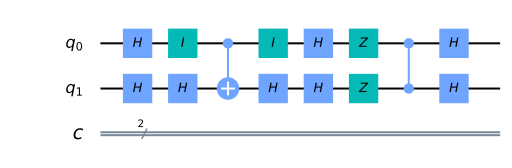

In [234]:
# Initialize quantum circuit with 2 bits
n = 2
grover_circuit = QuantumCircuit(n,n)

# Superposition
for qubit in range(n):
    grover_circuit.h(qubit)
    
# Oracle Uf (sign flip |11>)
grover_circuit.h(1)
grover_circuit.i(0)
grover_circuit.cx(0,1)
grover_circuit.h(1)
grover_circuit.i(0)

# Reflection Us 
for qubit in range(n):
    grover_circuit.h(qubit)
for qubit in range(n):
    grover_circuit.z(qubit)
grover_circuit.cz(0,1)
for qubit in range(n):
    grover_circuit.h(qubit)

# draw circuit
%matplotlib inline
grover_circuit.draw('mpl')


### Simulate circuit on 'statevector_simulator' to obtain statevector output

In [235]:
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(grover_circuit, backend_sim)
final_state = job_sim.result().get_statevector()
print(final_state)

[7.85046229e-17+0.0000000e+00j 1.66533454e-16+1.8369702e-16j
 7.85046229e-17+1.8369702e-16j 1.00000000e+00-3.6739404e-16j]


### Simulate circuit on 'qasm_simulator' to obtain results for 1024 shots

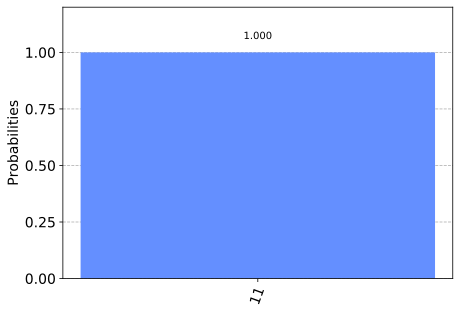

In [236]:
grover_circuit.measure(grover_circuit.qregs[0],grover_circuit.cregs[0])
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

### Now, we add noise

### Create a noise model that causes qubit gate errors at cx gates (applied to each qubit independently)

In [237]:
def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
#     noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
#     noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_gate1, ["z"]) # single qubit gate error is applied to z gates. 
                                                                # z gate is used in grover diffusion operator on each qubit
    
    return noise_model

### Running the circuit with the noise model and extract the counts

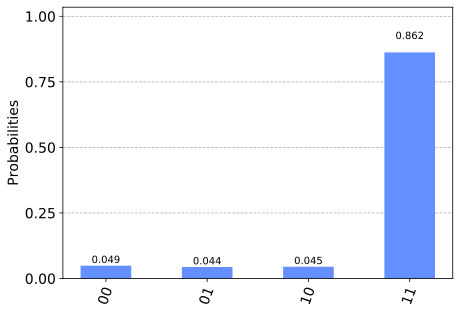

In [238]:
grover_circuit.measure(grover_circuit.qregs[0],grover_circuit.cregs[0])
noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(noisy_counts)

### Show outputs across a range of noise levels

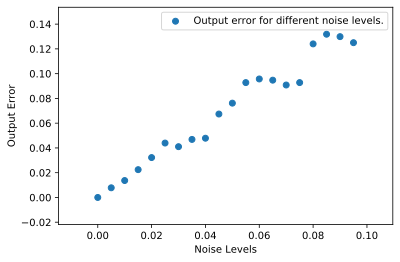

In [239]:
n = 20
ind = 0
noise_range = [i * 0.005 for i in range(n)]
output_error = []
for noise in noise_range:
    noise_model = get_noise(noise,noise)
    noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    output_error.append(1.-noisy_counts['11'] / (sum(noisy_counts.values())))
    if ind == 1 or ind == 19:
        plot_histogram(noisy_counts)
    ind+=1
    
    
ax = plt.gca()
plt.xlabel('Noise Levels')
plt.ylabel('Output Error')
ax.scatter(noise_range, output_error, label="Output error for different noise levels.")
plt.legend()
plt.show()

### Running the circuit on IBM's hardware

In [240]:
# Running circuit on IBM hardware
job = execute(grover_circuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job incurred error     


In [241]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

IBMQJobFailureError: 'Unable to retrieve result for job 5ea87fbf25c49f001879f532. Job has failed. Use job.error_message() to get more details.'

## Grover Circuit for |01>

### First, let's make sure that the oracle gives us the ouput we want

In [242]:
# Test that the oracle flips the sign on |01> 
n = 2
init = tensor(snot()*basis(2,0),snot()*basis(2,0))
psi1 = tensor(sigmax(),snot())*init
psi2 = cnot()*psi1
psi3 = tensor(sigmax(),snot())*psi2
print(init)
print(psi3)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.5]
 [0.5]
 [0.5]
 [0.5]]
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.5]
 [-0.5]
 [ 0.5]
 [ 0.5]]


### Building the circuit

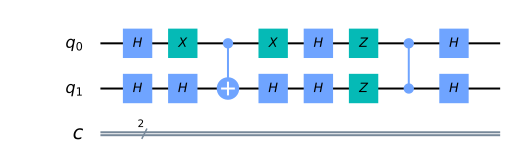

In [243]:
# Initialize quantum circuit with 2 qubits
n = 2
grover_circuit = QuantumCircuit(n,n)

# Superposition
for qubit in range(n):
    grover_circuit.h(qubit)
    
# Oracle Uf (flips sign of |01>) 
# Note: The order of the tensor product in QuantumCircuit is [a00, a10, a01, a11], where the first number is
# the least significant qubit. This is different from qutip, which is ordered [a00, a01, a10, a11]
grover_circuit.h(1)
grover_circuit.x(0)
grover_circuit.cx(0,1)
grover_circuit.h(1)
grover_circuit.x(0)

# Reflection Us 
for qubit in range(n):
    grover_circuit.h(qubit)
for qubit in range(n):
    grover_circuit.z(qubit)
grover_circuit.cz(0,1)
for qubit in range(n):
    grover_circuit.h(qubit)

# draw circuit
%matplotlib inline
grover_circuit.draw('mpl')

### Simulate circuit on 'statevector_simulator' to obtain statevector output

In [244]:
# Run Grover's
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(grover_circuit, backend_sim)
final_state = job_sim.result().get_statevector()
print(final_state)

[ 1.11022302e-16+6.12323400e-17j -3.92523115e-17+4.93038066e-32j
  1.00000000e+00-3.67394040e-16j -3.92523115e-17+1.83697020e-16j]


### Simulate circuit on 'qasm_simulator' to obtain results for 1024 shots

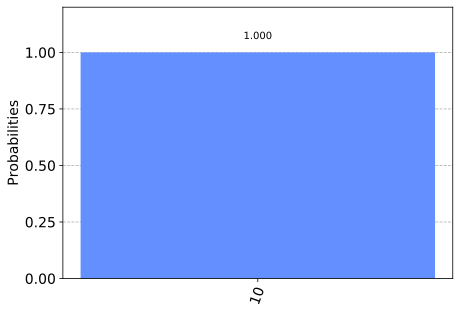

In [245]:
grover_circuit.measure(grover_circuit.qregs[0],grover_circuit.cregs[0])
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

### Now, we add noise

### Running the circuit with the same noise model as before and extract the counts

In [246]:
noise = 0.1
noise_model = get_noise(noise, noise)

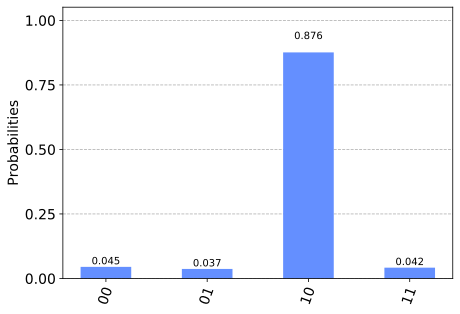

In [247]:
grover_circuit.measure(grover_circuit.qregs[0],grover_circuit.cregs[0])
noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(noisy_counts)

### Show outputs across a range of noise levels

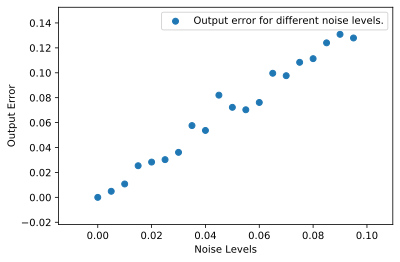

In [248]:
n = 20
ind = 0
noise_range = [i * 0.005 for i in range(n)]
output_error = []
for noise in noise_range:
    noise_model = get_noise(noise,noise)
    noisy_counts = execute(grover_circuit, Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()
    output_error.append(1.-noisy_counts['10'] / (sum(noisy_counts.values())))
    
ax = plt.gca()
plt.xlabel('Noise Levels')
plt.ylabel('Output Error')
ax.scatter(noise_range, output_error, label="Output error for different noise levels.")
plt.legend()
plt.show()

### Running the circuit on IBM's hardware

In [249]:
# Running circuit on IBM hardware
job = execute(grover_circuit, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job incurred error     


In [250]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

IBMQJobFailureError: 'Unable to retrieve result for job 5ea87fd83866640019174f07. Job has failed. Use job.error_message() to get more details.'